# Plant disease recognition with CNN Neural Networks on advance level¶
**Author: Ankit Garg**

- LinkedIn: (https://www.linkedin.com/in/ankit-garg453/)

# 1. Import libraries and fetch data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Input data files are available in the read-only "../input/" directory
train_images, test_images, validation_images = [],[],[]
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        if 'Test' in str(os.path.join(dirname, filename)):
            test_images.append(os.path.join(dirname, filename))
        if 'Train' in str(os.path.join(dirname, filename)) or 'Validation' in str(os.path.join(dirname, filename)):
            train_images.append(os.path.join(dirname, filename))
        #     if len(unique_images) < 4:
        #         unique_images.append(os.path.join(dirname, filename))
        # elif 'Validation' in str(os.path.join(dirname, filename)):
        #     validation_images.append(os.path.join(dirname, filename))

# - 1.1 Set displays

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)

CPU times: total: 0 ns
Wall time: 0 ns


- Fetch one image of all types.

In [3]:
unique_images = {}
for path in train_images:
    directory = os.path.dirname(path)
    if directory not in unique_images:
        unique_images[directory] = path  

unique_image_list = list(unique_images.values())

print("Unique images from each directory:")
unique_image_list

Unique images from each directory:
CPU times: total: 0 ns
Wall time: 2.52 ms


['data\\Train\\Train\\Healthy\\800edef467d27c15.jpg',
 'data\\Train\\Train\\Powdery\\802f7439ec1ef0cd.jpg',
 'data\\Train\\Train\\Rust\\807947b90eb77856.jpg',
 'data\\Validation\\Validation\\Healthy\\9bd4cc8c52e9d52a.jpg',
 'data\\Validation\\Validation\\Powdery\\8f6737815b2cd234.jpg',
 'data\\Validation\\Validation\\Rust\\8030a3a79fca6abb.jpg']

# - 1.2 Display Images

CPU times: total: 266 ms
Wall time: 854 ms


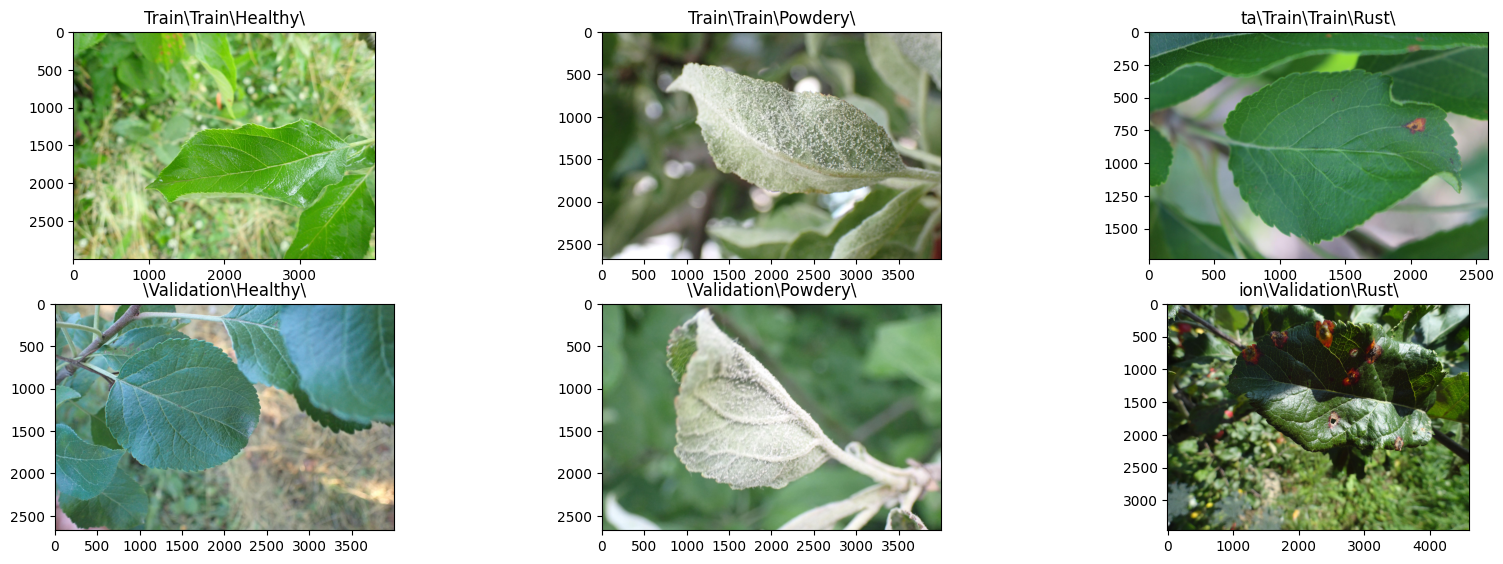

In [4]:
plt.figure(figsize=(20,10))
col = 10
categories = ['Healthy','Powdery', 'Rust']
# filtered_values = df[df['your_column_name'].str.contains(target_string, na=False)]
# fd = [img for img in train_images if 'Healthy' in img]
common_path = '/kaggle/input/plant-disease-recognition-dataset/'
for i, img_loc in enumerate(unique_image_list):
    plt.subplot(3, 3, i+1)
    img = plt.imread(img_loc)
    plt.title(img_loc[-40:-20])
    plt.imshow(img)

# 2. Create DataFrames

In [8]:
all_images = [train_images, test_images]
dataframe_names = ['train_images', 'test_images']

df_dictionary = {'train_images': pd.DataFrame(), 'test_images': pd.DataFrame()}

for one_type, name in zip(all_images, dataframe_names):
    img_path, sub_folders, images = [], [], []  # Reset lists

    for path in one_type:
        all_paths = path.split('/')
        img_path.append('/'.join(all_paths[:6]))
        sub_folders.append(all_paths[6])
        images.append(all_paths[7])

    # Create a DataFrame for the current dataset
    df_dictionary[name] = pd.DataFrame({
        'img_path': img_path,
        'sub_folders': sub_folders,
        'images': images
    })

train_df = df_dictionary['train_images']
test_df = df_dictionary['test_images']


CPU times: total: 0 ns
Wall time: 1.02 ms


# 3. Pre-processing

In [9]:
# Setup sizes for batch, image height and width
batch_size = 32
img_height = 224
img_width = 224

CPU times: total: 0 ns
Wall time: 0 ns


# - 3.1 Prepare training data

In [10]:
training_validation_images_path = 'data/Train/Train/'
train_ds = tf.keras. utils.image_dataset_from_directory(
    training_validation_images_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1322 files belonging to 3 classes.
Using 1058 files for training.
CPU times: total: 15.6 ms
Wall time: 181 ms


**We connected the data for training images and validation data to provide more data to model, so that model get train well. This is one of the approaches. But the approach is, rather to be joining both the data's (training and validation) let it be splitted and make diffferent datasets and then train them at step 3.1 and step 3.2 with different paths of image sets.**

# - 3.2 Prepare validation data

In [11]:
validation_ds = tf.keras. utils.image_dataset_from_directory(
    training_validation_images_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 1322 files belonging to 3 classes.
Using 264 files for validation.
CPU times: total: 0 ns
Wall time: 78.5 ms


- Get labels

In [12]:
label_names = train_ds.class_names
label_names

CPU times: total: 0 ns
Wall time: 0 ns


['Healthy', 'Powdery', 'Rust']

- Check sizes, shapes of training and labels

In [13]:
for img_batch, label_batch in train_ds:
    print(img_batch.shape)
    print(label_batch.shape)
    break

(32, 224, 224, 3)
(32,)
CPU times: total: 4.52 s
Wall time: 524 ms


# - 3.3 Data Normalization

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y:(normalization_layer(x),y))

Cause: could not parse the source code of <function <lambda> at 0x000002619DF691C0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x000002619DF691C0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: total: 0 ns
Wall time: 17.1 ms


# - 3.4 Auto-tune data(to make system/ training faster)

In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

CPU times: total: 0 ns
Wall time: 20.1 ms


# - 3.5 Normalize entire data

In [16]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(f"{np.min(first_image)}, {np.max(first_image)}")

0.047458209097385406, 1.0
CPU times: total: 2.62 s
Wall time: 330 ms


- Get total number of outputs, to define in output layer

In [17]:
num_classes = len(label_names)
num_classes

CPU times: total: 0 ns
Wall time: 0 ns


3

# 4. Model Prepration with Neural Network and Conv layers

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.10),
    # tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

CPU times: total: 0 ns
Wall time: 9.2 ms


# - 4.1 Compile model with right functions as per data

In [19]:
model.compile(optimizer='adam',
             loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

CPU times: total: 0 ns
Wall time: 13 ms


# - 4.2 Train model with EarlyStopping, and also saving the records
- This also give details about the accuracy and error loss of the model
- Final we will get evaluation results, that model will test on validation data.

In [20]:
early_stopping = EarlyStopping(patience=12)
records = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stopping])
loss, accuracy = model.evaluate(val_ds)
print(f"Validate Loss : {loss}")
print(f"Validate Accuracy : {accuracy}")

Epoch 1/20


c:\Users\rkhdi\OneDrive\Desktop\Skripsi\Plant Disease Recognition\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.3941 - loss: 1.3390 - val_accuracy: 0.7083 - val_loss: 50.9029
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.6967 - loss: 0.6549 - val_accuracy: 0.6932 - val_loss: 72.3576
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.7935 - loss: 0.5027 - val_accuracy: 0.8068 - val_loss: 51.1840
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 372ms/step - accuracy: 0.8691 - loss: 0.3603 - val_accuracy: 0.8409 - val_loss: 47.3221
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.9013 - loss: 0.2935 - val_accuracy: 0.8523 - val_loss: 41.7862
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - accuracy: 0.9409 - loss: 0.2197 - val_accuracy: 0.8636 - val_loss: 43.0447
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 356ms/step - accuracy: 0.9534 - loss: 0.1624 - val_accuracy: 0.8561 - val_loss: 46.4774
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9449 - loss: 0.1697 - val_accuracy: 0

# 6. Output Observations
- **Model gave 99% accuracy on training data.**
- **85% accuracy on validation data.**

# 5. Get plots on model for loss and accuracy on Training and Validation data.

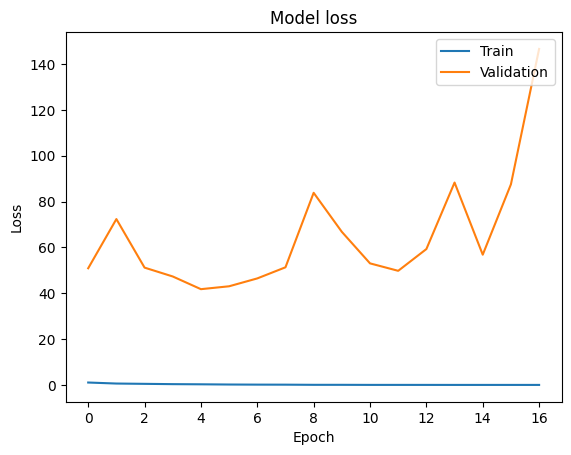

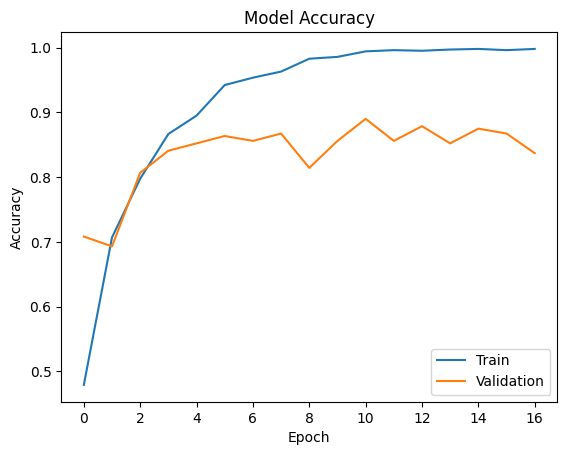

CPU times: total: 93.8 ms
Wall time: 227 ms


In [21]:
# Plotting the training and testing loss
import matplotlib.pyplot as plt
plt.plot(records.history['loss'])
plt.plot(records.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plot the accuracy of training and validation

# Plotting the training and validation accuracy
plt.plot(records.history['accuracy'])
plt.plot(records.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# - 5.1 Saving the model.

In [ ]:
model.save('plant_disease_recognition_cnn_model.keras')